## osumapper: create osu! map using Tensorflow and Colab

### Model Training

Github: https://github.com/kotritrona/osumapper

### Step 0: Installation

First of all, check the Notebook Settings under Edit tab.<br>
Activate GPU to make the training faster.

Then, clone the git repository and install dependencies.

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# Joe's cell
DRIVE_PATH = 'drive/MyDrive/Cal/Colab/DeepMusicVisualizer'

In [ ]:
# Richard's cell
DRIVE_PATH = 'drive/MyDrive/cs194/DeeperMusicVisualizer'

In [15]:
%cd $DRIVE_PATH

[Errno 2] No such file or directory: 'drive/MyDrive/Cal/Colab/DeepMusicVisualizer'
/content/drive/MyDrive/Cal/Colab/DeepMusicVisualizer/rhythm


In [16]:
%cd rhythm

[Errno 2] No such file or directory: 'rhythm'
/content/drive/MyDrive/Cal/Colab/DeepMusicVisualizer/rhythm


In [17]:
#%cd /content/
#!git clone https://github.com/kotritrona/osumapper.git
#%cd osumapper/v7.0
!apt install -y ffmpeg
!apt install -y nodejs
#!cp requirements_colab.txt requirements.txt
#!cp package_colab.json package.json
!pip install -r requirements_colab.txt
!npm install

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
nodejs is already the newest version (8.10.0~dfsg-2ubuntu0.4).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
audited 76 packages in 0.951s
found 0 vulnerabilities



   ╭────────────────────────────────────────────────────────────────╮
   │                                                                │
   │      New major version of npm available! 6.14.8 → 7.12.0       │
   │   Changelog: htt

Generate a new maplist.txt

In [7]:
!python maplist_creator.py

Please enter the path to your osu songs folder for training: /content/drive/MyDrive/Cal/Colab/DeepMusicVisualizer/data/beatmaps_57
Show verbose output? y/n: y
/content/drive/MyDrive/Cal/Colab/DeepMusicVisualizer/data/beatmaps_57/Aeonian/beatmap.osu
/content/drive/MyDrive/Cal/Colab/DeepMusicVisualizer/data/beatmaps_57/BrainPower/beatmap.osu
/content/drive/MyDrive/Cal/Colab/DeepMusicVisualizer/data/beatmaps_57/Earthquake/beatmap.osu
/content/drive/MyDrive/Cal/Colab/DeepMusicVisualizer/data/beatmaps_57/Faded/beatmap.osu
/content/drive/MyDrive/Cal/Colab/DeepMusicVisualizer/data/beatmaps_57/Astronomia/beatmap.osu
/content/drive/MyDrive/Cal/Colab/DeepMusicVisualizer/data/beatmaps_57/MarbleSoda/beatmap.osu
/content/drive/MyDrive/Cal/Colab/DeepMusicVisualizer/data/beatmaps_57/GiveItUp/beatmap.osu
/content/drive/MyDrive/Cal/Colab/DeepMusicVisualizer/data/beatmaps_57/Griztronics/beatmap.osu
/content/drive/MyDrive/Cal/Colab/DeepMusicVisualizer/data/beatmaps_57/Goodbye/beatmap.osu
/content/drive/M

### Step 1: Upload training maps

Write the maplist.txt and run the first block of `01_Training.ipynb` (`act_data_prep.step1_load_maps()`) locally.<br>
After that, make a folder `NPZ/` under your google drive, and upload the generated npz files under local `mapdata/` in there.

In [8]:
# Wait for the upload to finish
from act_data_prep import *
# for osu!mania use this instead of above
# from mania_act_data_prep import * 
step1_load_maps();

Number of filtered maps: 27
{ Error: ENOENT: no such file or directory, open ''
    at Object.fs.openSync (fs.js:646:18)
    at Object.fs.readFileSync (fs.js:551:33)
    at main (/content/drive/My Drive/Cal/Colab/DeepMusicVisualizer/rhythm/load_map.js:1395:26)
    at Object.<anonymous> (/content/drive/My Drive/Cal/Colab/DeepMusicVisualizer/rhythm/load_map.js:1484:1)
    at Module._compile (module.js:652:30)
    at Object.Module._extensions..js (module.js:663:10)
    at Module.load (module.js:565:32)
    at tryModuleLoad (module.js:505:12)
    at Function.Module._load (module.js:497:3)
    at Function.Module.runMain (module.js:693:10) errno: -2, code: 'ENOENT', syscall: 'open', path: '' }

Error on #0, path = , error = Map Convert Failure
Map data #1 saved! time = 6.025467157363892 secs
Map data #2 saved! time = 3.7364814281463623 secs
Map data #3 saved! time = 4.331708192825317 secs
Map data #4 saved! time = 3.712470054626465 secs
Map data #5 saved! time = 3.556828022003174 secs
Map da

Mount your google drive in Colaboratory.<br>
It will ask you for an auth code.


In [ ]:
#from google.colab import drive
#drive.mount('/gdrive')

Copy .npz files to the training data folder.

In [ ]:
# One of mkdir or rm will pop an error. Ignore it.
#!mkdir mapdata/
#!rm mapdata/*.npz
#!cp /gdrive/'My Drive'/NPZ/*.npz mapdata/
#print("Copy complete!")

In [9]:
%load_ext autoreload
%autoreload 2

## Step 2: rhythm model

(after this point it's copypaste from `01_Training.ipynb` from the second block)

Train a rhythm model that decides where to place circles/sliders based on music.

If you're using GPU and it reports a memory error, try setting batch_size parameter to a smaller value (that GPU can handle).

In [10]:
%reload_ext autoreload

from act_train_rhythm import *

train_params = {
    "divisor" : 8,
    "train_epochs" : 50,
    "train_batch_size" : None, # Default is 32 or based on machine specs
    "plot_history" : True,
    "too_many_maps_threshold" : 240,
    "train_epochs_many_maps" : 6,
    "data_split_count" : 80
};
model = step2_build_model()

bidirectional LSTM-128
daata (3633, 7, 32, 2) (3633, 7, 32, 2)
label (3633, 8) (3633, 5)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.



Train the model and evaluate.
is_note_start accuracy should be about 0.8 to 0.9 based on my tests, others should be lower.

**Note:** I changed the metrics from F1 to AUC in this version!! 0.5=guessing 1=perfect for AUC

divisor 8
daata (3633, 7, 32, 2) (3633, 7, 32, 2)
label (3633, 8) (3633, 5)
daata (66058, 7, 32, 2) (66058, 7, 32, 2)
label (66058, 8) (66058, 5)
preprocessed data (4128, 16, 7, 32, 2)
preprocessed div (4128, 16, 11)
preprocessed label (4128, 16, 5)
final train labels AFTER validation split (3895, 16, 5)
final train data AFTER validation split (3895, 16, 7, 32, 2)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

..................................................daata (3633, 7, 32, 2) (3633, 7, 32, 2)
label (3633, 8) (3633, 5)
daata (3633, 7, 32, 2) (3633, 7, 32, 2)
label (3633, 8) (3633, 5)
preprocessed data (227, 16, 7, 32, 2)
preprocessed div (227, 16, 11)
preprocessed label (227, 16, 5)
daata (2479, 7, 32, 2) (2479, 7, 32, 2)
label (2479, 8) (2479, 5)
preprocessed data (154, 16, 7, 32, 2)
preprocessed div (154, 16, 11)
pr

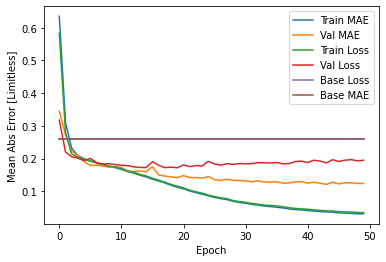

daata (3633, 7, 32, 2) (3633, 7, 32, 2)
label (3633, 8) (3633, 5)
is_note_start auc score: 0.9583366453285852
is_circle auc score: 0.9022462138127608
is_slider auc score: 0.9519575478105305
is_note_end auc score: 0.9103347015158457


In [11]:
%reload_ext autoreload
from act_train_rhythm import *

model = step2_train_model(model, train_params)
step2_evaluate(model)

Done! now save the model to the disk.

In [12]:
from google.colab import files

step2_save(model,"rhythm_model_8_LSTM128_overfit.h5")
#files.download("saved_rhythm_model")

## Step 3: flow dataset construction

Construct a dataset for the map flow generator.

In [ ]:
from act_flow_ds import *;

flow_dataset_params = step3_set_params(note_group_size=10, step_size=5);
maps_flow = step3_read_maps_flow(flow_dataset_params);
step3_save_flow_dataset(maps_flow);
files.download("flow_dataset.npz")

# hitsounds dataset, only for taiko maps
# maps_hs_af, maps_hs = step3_read_maps_hs(flow_dataset_params);
# step3_save_hs_dataset(maps_hs_af, maps_hs);
# files.download("hs_dataset.npz")

# pattern dataset, only for mania (remove the flow part for mania)
# data = step3_read_maps_pattern([]);
# step3_save_pattern_dataset(data);
# files.download("mania_pattern_dataset.npz")

Replace the default model files to use it in Colab map creator.

In [ ]:
!cp saved_rhythm_model models/default/rhythm_model
!cp flow_dataset.npz models/default/flow_dataset.npz
# !cp hs_dataset.npz models/default/hs_dataset.npz
# !cp mania_pattern_dataset.npz models/default/mania_pattern_dataset.npz

That's it! The models are trained. Start making a new map with the other notebook.

For bug reports and feedbacks either report it on github or use discord: <br>
[https://discord.com/invite/npmSy7K](https://discord.com/invite/npmSy7K)